# Major Project: Predictng Emotions from Faces



# Module Import



In [ ]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import InceptionV3,MobileNetV2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model

In [ ]:
drive.mount('/content/drive/')
dataset_directory = '/content/drive/MyDrive/Masters2022-2024/COMP8220-MachineLearning/MajorProject/Data'

Mounted at /content/drive/


# Data Loading

In [ ]:
image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size,1])/255.0 # reshape the images for grayscale
images_test_public = images_test_public.reshape([-1, image_size, image_size,1])/255.0

print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)

(9328, 48, 48, 1)
(9328,)
(1136, 48, 48, 1)


In [ ]:
dataset_size, height, width, gray = images_train.shape

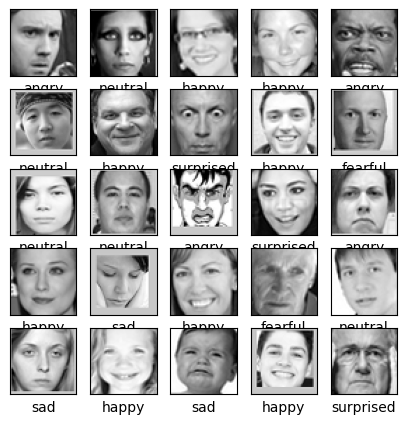

In [ ]:
plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

### Label Distribution

From the chart below, we can see a clear class imbalance. '3' is the most populated class followed by 6, 0 and then 2. 1 is the least populated class. This class imbalance will have impacts on our accuracy scores as there is not enough data to make accurate predictions on whether a face belongs to the 'disgusted' category.

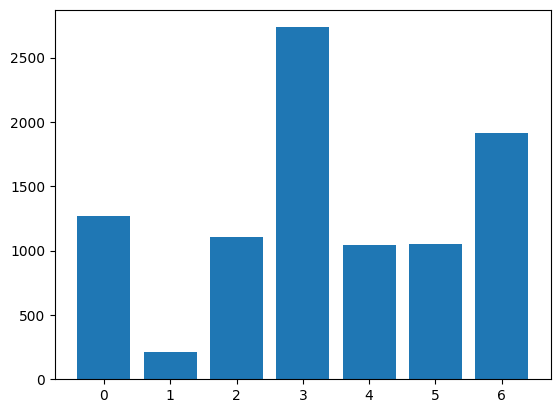

In [ ]:
unique, counts = np.unique(labels_train, return_counts=True)
train = dict(zip(unique, counts))


D = train
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

### Imbalanced Classes

Because our classes are quite imbalanced, we should redistribute them. I came across this function in [stackoverflow](https://stackoverflow.com/questions/35472712/how-to-split-data-on-balanced-training-set-and-test-set-on-sklearn/47555856#47555856) that can aid in balancing out the classes.

This should work better rather than sklearn's `train_test_split` function which may not evenly distribute the classes with its randomisation.

In [ ]:

def split_balanced(data, target, test_size=0.2):

    classes = np.unique(target)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test


In [ ]:

X_train, X_valid, y_train, y_valid = split_balanced(images_train,
                                                    labels_train,
                                                    test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(7462, 48, 48, 1)
(1862, 48, 48, 1)
(7462,)
(1862,)


Repeating the same visualisations above lets see how each class is distributed now.

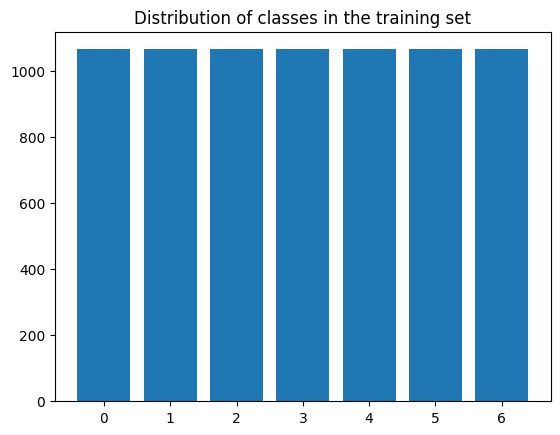

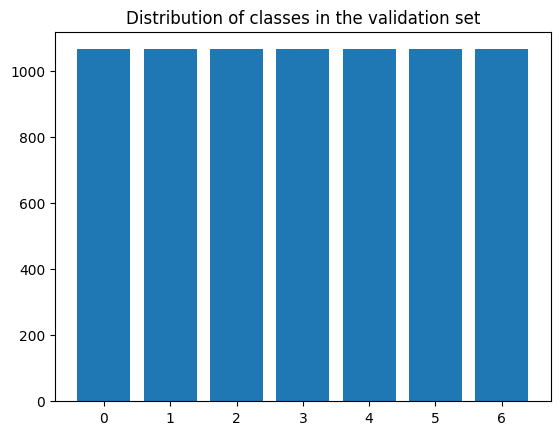

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
Xtrain = dict(zip(unique, counts))


D = Xtrain
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.title("Distribution of classes in the training set")
plt.show()


unique, counts = np.unique(y_valid, return_counts=True)
Xvalid = dict(zip(unique, counts))


D1 = Xvalid
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.title("Distribution of classes in the validation set")
plt.show()

This is so much better than before in terms of our balanced sets.

# Extracting HOG features

Histogram of Gradients (HOG) is an image descriptor. HOG descriptors globally normalises the image and computes its horizontal and vertical gradients, flattening it into a descriptor vector. The gradients show how the brightness of the pixels changes from one part of the image to another. The block normalisation makes the descriptor more robust to changes in contrast and lighting.

Part of the analysis involves extracting meaningful features from an image and using it to predict the emotion classes. I found that throughout all the conventional machine learning and deep learning techniques (excluding those cases where I implemented transfer learning), models trained using HOG features outperfomed a regular model by giving accuracies of more than 5%.

In [ ]:
def extract_hog_features(image):
    fd, hog_image = hog(image.reshape((48, 48)), pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return fd

# Extract HOG features for the training data
X_train_hog = np.array([extract_hog_features(image) for image in X_train])

# Extract HOG features for the validation data
X_valid_hog = np.array([extract_hog_features(image) for image in X_valid])

# Extract HOG features for the unseen test data
X_test_hog = np.array([extract_hog_features(image) for image in images_test_public])

# Extract HOG features for the unseen Private test data
X_test_hog = np.array([extract_hog_features(image) for image in images_test_public])

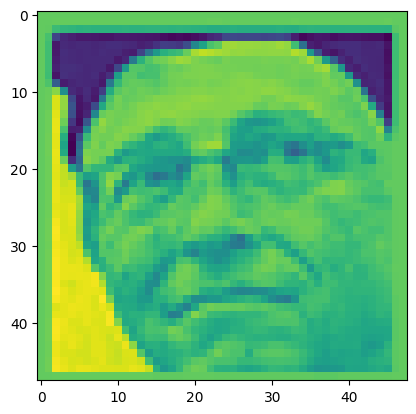

In [ ]:
sample =30
image = images_train[sample].reshape(48, 48)
plt.imshow(images_train[sample].reshape(48, 48))
plt.show()

In [ ]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(48, 48), cells_per_block=(1, 1), visualize=True)
print(image.shape, len(fd))
# ((256L, 256L), 2048)


(48, 48) 8


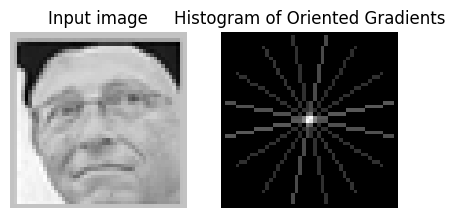

In [ ]:
import matplotlib.pyplot as pylab
fig, (axes1, axes2) = pylab.subplots(1, 2, figsize=(5,5), sharex=True, sharey=True)
axes1.axis('off')
axes1.imshow(image, cmap=pylab.cm.gray)
axes1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

axes2.axis('off')
axes2.imshow(hog_image_rescaled, cmap=pylab.cm.gray)
axes2.set_title('Histogram of Oriented Gradients')
pylab.show()

# Conventional ML: SVM

The best performing conventional model was the Support Vector machine classification model based on the HOG features.
I tried several conventional machine learning models such as KNN, Gaussian Bayes, Logistic regression and random forests

For the SVC classifier I played around with [hyperparameter](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769) tuning and found that the best model (before splitting for balanced classes) was with a `C=4.0, gamma ='scale', kernel ='rbf'`. This model gave me an accuracy of 62.7% on the validation set and 60.2% on the private set on Kaggle placing me 9th on the leaderboard at the time of submission.

I suspect SVC's high accuracy was due to fact that it operates on being a 1vsall classifier. Since class 3 was the majority class, it would be predicting class 3 accurately over and over again but not very accurately predicting the other classes. So I retuned my model to find another set of hyper-parameters that would give me the best accuracy. The best model returned a training accuracy of 75% with the following parameters `C=5.5, gamma ='scale', kernel ='rbf'`When I ran that same model with the same hyperparameters,now that the classes are evenly split the accuracy actually falls to 53.8%.



In [ ]:
nsamples, nx, ny,col = X_train.shape
X_train2 = X_train.reshape(nsamples,nx*ny)
nsamples_valid, nx, ny,col = X_valid.shape
X_valid2 = X_valid.reshape(nsamples_valid,nx*ny)

In [ ]:
param_grid = [{'kernel': ['rbf'], 'C': np.arange(1,5+1,0.5), 'gamma': ['scale', 'auto']}]

svc_clfrbf = SVC()
grid_search = GridSearchCV(svc_clfrbf, param_grid, verbose=3)
grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.650 total time= 1.4min
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.632 total time= 1.2min
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.647 total time= 1.3min
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.627 total time= 1.1min
[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.641 total time= 1.1min
[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.236 total time= 1.5min
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.199 total time= 1.5min
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.259 total time= 1.8min
[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.228 total time= 1.6min
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.227 total time= 1.4min
[CV 1/5] END ....C=1.5, gamma=scale, kernel=rbf;, score=0.687 total time=  58.8s
[CV 2/5] END ....C=1.5, gamma=scale, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']}],
             verbose=3)

In [ ]:
grid_search.best_params_
#grid_search.best_estimator_

{'C': 5.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
best_svm = grid_search.best_estimator_
svm_pred2 = best_svm.predict(X_valid2)

In [ ]:
accuracy_score(svm_pred2, y_valid)

0.46509129967776586

In [ ]:
# refitting with HOG - balanced classes
from sklearn.svm import SVC
svc_clfhog = SVC(C= 5.5, gamma= 'scale', kernel= 'rbf')
svc_clfhog.fit(X_train_hog, y_train)
svc_predhog = svc_clfhog.predict(X_valid_hog)

In [ ]:
accuracy_score(svc_predhog, y_valid)

0.533297529538131

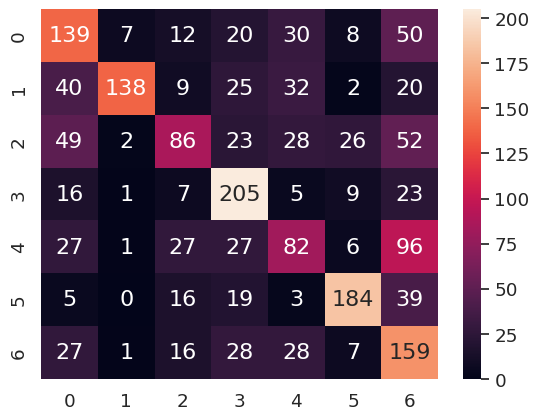

In [ ]:
cm =confusion_matrix(y_valid,svc_predhog)
df_cm = pd.DataFrame(cm, range(7), range(7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")
plt.show()

#### Comments:

While the accuracy with more balanced classes is lower than the unbalanced classes, we can see that all classes are being correctly labelled overall. Whereas before class 3 ( see heatmap below) was the only class being correctly predicted leading to an overall higher accuracy. Overall, we would prefer the current SVM model with balanced classes due to its ability to accurately predict other classes not just class 3. This is in comparison to the highest accuracy  score of 75% on the kaggle leader board.



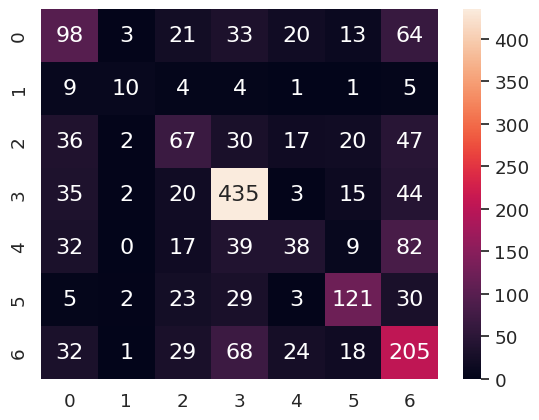

In [ ]:
svc_pred_test = svc_clfhog.predict(X_test_hog)

In [ ]:
df=pd.DataFrame(svc_pred_test)
dataset_directory = '/content/drive/MyDrive/Masters2022-2024/COMP8220-MachineLearning/MajorProject/Data/SVM_CLF_HOG_23102023.csv'

with open(dataset_directory , 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f, index_label = "ID", header  = ['Predictions'])

Submitting the SVC HOG features to kaggle, this produced an accuracy of 58.09% which was not far off from the previous submission of 60.02%

I also tried scaling the input features since we know that SVC classifiers are sensitive to feature scaling. I used the MinMaxScaler() on the HOG features and was able to get an accuracy of 60.9% on the unbalanced classes reported below. For the final submission on the private set I got an accuracy of 62.7% which placed me 16th on the leader board. The top scoring accuracy was 80%. Upon talking with other classmates it was because this person had used a RESNET50 model in combination with 45,000 additional images to train and predict his images.

I will discuss my attempts at transfer learning in the third and final section.

In [ ]:
scaler = MinMaxScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_val_hog = scaler.transform(X_valid_hog)
X_test_hogscale =scaler.transform(X_test_hog)

In [ ]:

# refitting with HOG - Unbalanced classes - scaled
from sklearn.svm import SVC
svc_clfhogscaled = SVC(C= 5.5, gamma= 'scale', kernel= 'rbf')
svc_clfhogscaled.fit(X_train_hog, y_train)
svc_predhogscale = svc_clfhogscaled.predict(X_val_hog)

In [ ]:
accuracy_score(svc_predhogscale, y_valid)

0.6093481989708405

In [ ]:
svc_pred_test = svc_clfhog.predict(X_test_hogscale)
df=pd.DataFrame(svc_pred_test)
dataset_directory = '/content/drive/MyDrive/Masters2022-2024/COMP8220-MachineLearning/MajorProject/Data/SVM_CLF_HOG_SCALED_24102023.csv'

with open(dataset_directory , 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f, index_label = "ID", header  = ['Predictions'])

In [ ]:

# refitting with HOG - Unbalanced classes - unscaled
from sklearn.svm import SVC
svc_clfhog = SVC(C= 5.5, gamma= 'scale', kernel= 'rbf')
svc_clfhog.fit(X_train_hog, y_train)
svc_predhog = svc_clfhog.predict(X_valid_hog)

In [ ]:
accuracy_score(svc_predhog, y_valid)

0.6042024013722127

In [ ]:
svc_pred_test = svc_clfhog.predict(X_test_hog)
df=pd.DataFrame(svc_pred_test)
dataset_directory = '/content/drive/MyDrive/Masters2022-2024/COMP8220-MachineLearning/MajorProject/Data/SVM_CLF_HOG_24102023.csv'

with open(dataset_directory , 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f, index_label = "ID", header  = ['Predictions'])

# Conventional ML: KNN

Like the SVC classifier above I tested a KNN model without hyperparameter and with hyperparameter tuning and found that the KNN model that produced the highest accuracy (using the unbalanced test sets) was a KNN classifier with Neighbors = 1 on HOG features. This produced an accuracy of 53%. Having the number of neighbors as 1 as the best model definitely points to overfitting. Therefore I will refit the model and do some hyper parameter tuning to find which set of parameters gives the best fitting model.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
knn_clf.fit(X_train2, y_train)
knn_pred = knn_clf.predict(X_valid2)

In [ ]:
accuracy_score(knn_pred, y_valid)

0.3292158968850698

Just fitting a base model with no hyperparameter training on the image data gives us a very poor accuracy of 32.9%. On the unbalanced tests the accuracy was similar and not much better 34%.

With some basic hyperparameter training, NN = 1 yielded 47% accuracy but since KNN is a distance based algorithm, NN=1 was a sure fire indication that the data was overfitting.

After some hyperparameter tuning on the unbalanced set I settled on `N_neighbors =1, weights = 'distance'` implementing this with HOG features I was able to get an accuracy of 53.91%.

In the refit of the model below, the best parameters we get are `N_neighbors =1, weights = 'uniform'` for non-HOG features. Yeilding a validation accuracy of 38.39%.



### KNN: Altering the weights

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [1,3, 4, 5]}]

knn_clf3 = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf3, param_grid, cv=5, verbose=3)
grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.683 total time=   3.2s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.687 total time=   1.6s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.678 total time=   1.3s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.656 total time=   1.3s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.668 total time=   1.3s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.683 total time=   1.3s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.687 total time=   1.2s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.678 total time=   1.7s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.656 total time=   2.4s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.668 total time=   1.4s
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.534 total time=   1.3s
[CV 2/5] END ....n_neighbors=3, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
grid_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
y_predValid = grid_search.predict(X_valid2)
accuracy_score(y_valid, y_predValid)

0.38399570354457574

Trying it with hog features we get a much better accuracy score of 48.2%. This is still not as good as the SVC classifier but it is better in practise than the KNN model fitting the unbalanced training and test sets.

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=1, weights = 'uniform')
knn_clf.fit(X_train_hog, y_train)
knn_pred_hog = knn_clf.predict(X_valid_hog)

In [ ]:
accuracy_score(y_valid, knn_pred_hog)

0.4822771213748657

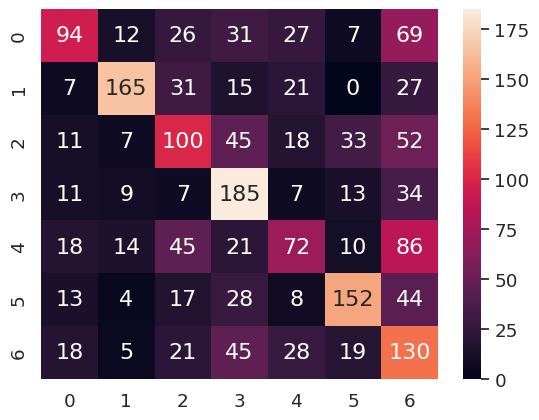

In [ ]:
cm =confusion_matrix(y_valid,knn_pred_hog)
df_cm = pd.DataFrame(cm, range(7), range(7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="g")
plt.show()

If we compare the above heatmap to a heatmap generated for the KNN model with a higher accuracy score submitted to Kaggle, we can see the completely poor classification accuracy for all other classes except for class 3. Atleast now with our balanced classes we have better overall accuracy which is preferred.

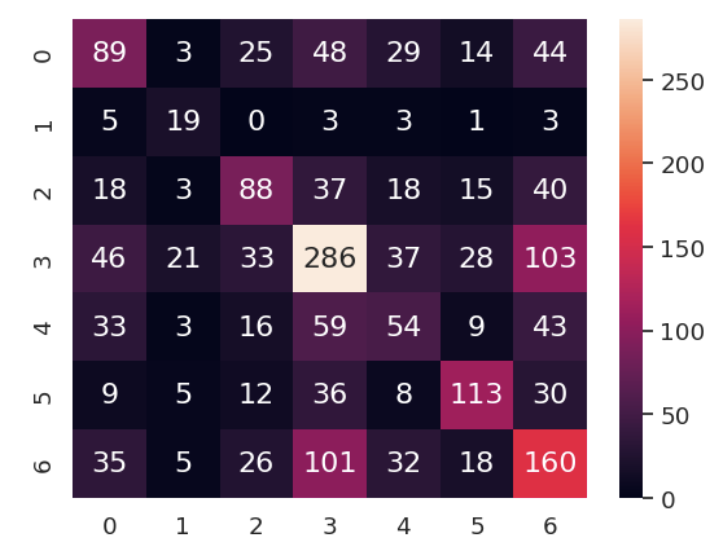

# Conventional ML: Conclusion
In addition to the KNN and SVC classifiers I played around with Random Forest, Gaussian Bayes and Logistic regression models to predict the emotional classes.
I chose these models to test because they are suitable for multi-class classification problems or in the case of logistic regression 1-vs-rest classifiers. Niether of these classifiers were able to get an accuracy of greater than 40%.
The guassian bayes classifier performed the worst with an accuracy of 20%.  I think this was the case because Naive Bayes assumes that all the pixels are independent and uncorrelated of eachother which is not true. Logistic regression wasn't able to scale well and predict accurately because of the 1-vs- rest architecture of the model. The classes were unbalanced at the time of testing and when given an 'angry' face would mis-classify it as something else and this was because only 13% of faces were classed as angry.


Apart from HOG features, I also tried extracting  Local Binary Histogram features (LPBH) for the image dataset and fitting the SVC model. I was only able to achieve an accuracy of 31% using the same SVC classifier and this is because LPBH features are mainly used for texture based image analysis tasks so are not that useful for face detection cases.

Overall, the SVC classifier trained on HOG features and scaled provided the best accuracy across the conventional and deep learning techniques for me personally.

# Deep Learning Techniques
I played around and created 26 models that leveraged different optimisers, activation functions and regularisation techniques.

In this section I will demonstrate the best models that I was able to produce using balanced classes. I will also provide discussion points based on my trials with the unbalanced classes and how that accuracy faired.

For these models I tried with and without HOG features. Overall the deep learner always performed better with HOG features than on just the raw images.

You can see my comments and exploration of the different activation functions at this link:

https://docs.google.com/spreadsheets/d/1opst50ysxU0my9uoDcGjPQqtqkzqh2YyHgevpTTnuMI/edit#gid=0


For this section I only used the unbalanced datasets.

In [ ]:
image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size,1])/255.0 # reshape the images for grayscale
images_test_public = images_test_public.reshape([-1, image_size, image_size,1])/255.0

from sklearn.model_selection import train_test_split
X_train, X_valid,y_train, y_valid = train_test_split(images_train,labels_train, test_size= 0.25, random_state= 47)

# Extract HOG features for the training data
X_train_hog = np.array([extract_hog_features(image) for image in X_train])

# Extract HOG features for the validation data
X_valid_hog = np.array([extract_hog_features(image) for image in X_valid])

### Model 16

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 10:
        return 0.005
    elif epoch < 15:
      return 0.0005
    else:
        return 0.00001


def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 10, 15], [0.01, 0.005,0.0005, 0.00001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [ ]:
image_size = 48
model16 = keras.models.Sequential([
     keras.layers.Flatten(input_shape=[image_size, image_size]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),

    keras.layers.Dense(7, activation="softmax")
])
model16.compile(loss="sparse_categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
n_epochs = 25
history16 = model16.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
219/219 [==============================] - 3s 8ms/step - loss: 1.6448 - accuracy: 0.3839 - val_loss: 1.7423 - val_accuracy: 0.2659 - lr: 0.0100
Epoch 2/25
219/219 [==============================] - 1s 6ms/step - loss: 1.4406 - accuracy: 0.4610 - val_loss: 1.5645 - val_accuracy: 0.4340 - lr: 0.0100
Epoch 3/25
219/219 [==============================] - 1s 6ms/step - loss: 1.3417 - accuracy: 0.5047 - val_loss: 1.4034 - val_accuracy: 0.4807 - lr: 0.0100
Epoch 4/25
219/219 [==============================] - 1s 6ms/step - loss: 1.2549 - accuracy: 0.5340 - val_loss: 1.4059 - val_accuracy: 0.5026 - lr: 0.0100
Epoch 5/25
219/219 [==============================] - 2s 7ms/step - loss: 1.1723 - accuracy: 0.5656 - val_loss: 1.5837 - val_accuracy: 0.4610 - lr: 0.0100
Epoch 6/25
219/219 [==============================] - 2s 9ms/step - loss: 0.9973 - accuracy: 0.6259 - val_loss: 1.4231 - val_accuracy: 0.5339 - lr: 0.0050
Epoch 7/25
219/219 [==============================] - 2s 8ms/step - lo

In [ ]:
model16.evaluate(X_valid, y_valid)

73/73 [==============================] - 0s 3ms/step - loss: 1.8348 - accuracy: 0.5467


[1.8347713947296143, 0.5467410087585449]

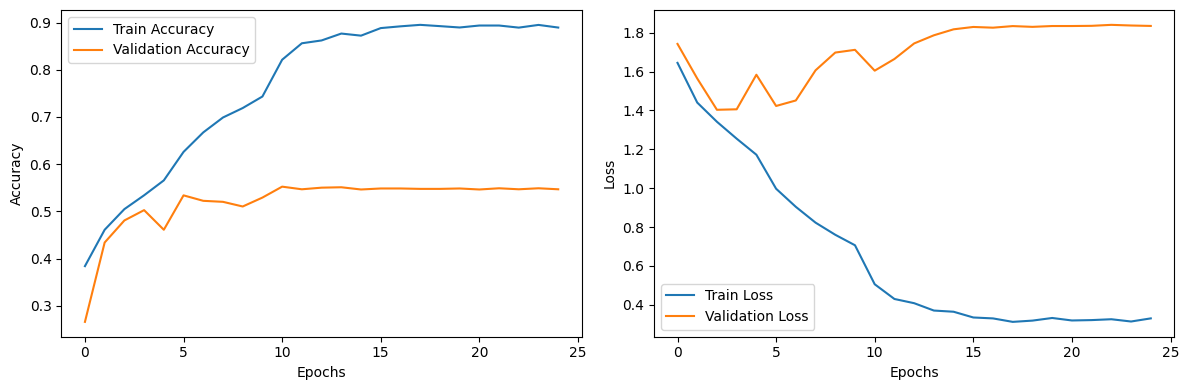

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Accuracy
axs[0].plot(history16.history['accuracy'], label='Train Accuracy')
axs[0].plot(history16.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot the Loss
axs[1].plot(history16.history['loss'], label='Train Loss')
axs[1].plot(history16.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()


plt.tight_layout()
plt.show()

#### Comments:

- Model16 uses Batchnormalisation as a regularisation technique to normalise each of the layers inputs.
- In comparison to previous models fitted implementing BatchNormalisation definitely improved the accuracy of these deep learners and solved the vanishing gradients problem (wihtout normalisation the validation accuracy was plateauing at 30% for non HOG features).
- I have also implemented piecewise scheduling in this model. By adjusting the learning rate, for different epochs I was hoping that the model would stabilise and generalise to the new and unseen data. However for the lowest learning rate, the validation accuracy was not that much better for higher learning rates.
- I  was hestitant try this model with HOG features since the validation accuracy was almost half of the training accuracy, a clear indication that the model is overfitting. From the above plots you can see the validation and training accuracies dramatically diverge and so does the loss. Validation loss also keeps increasing  while the training loss decreases.
- But we do get a decent validation accuracy on Model 16 on the unbalanced classes 54.67% and a loss of 1.8 and a learning rate of 1.0000e-05



In [ ]:
model16hog = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),

    keras.layers.Dense(7, activation="softmax")
])
model16hog.compile(loss="sparse_categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
n_epochs = 25
history16hog = model16hog.fit(X_train_hog, y_train, epochs=n_epochs,
                    validation_data=(X_valid_hog, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
219/219 [==============================] - 6s 10ms/step - loss: 1.4074 - accuracy: 0.4840 - val_loss: 1.4204 - val_accuracy: 0.4820 - lr: 0.0100
Epoch 2/25
219/219 [==============================] - 1s 6ms/step - loss: 1.1647 - accuracy: 0.5666 - val_loss: 1.2491 - val_accuracy: 0.5566 - lr: 0.0100
Epoch 3/25
219/219 [==============================] - 1s 6ms/step - loss: 1.0065 - accuracy: 0.6281 - val_loss: 1.2546 - val_accuracy: 0.5540 - lr: 0.0100
Epoch 4/25
219/219 [==============================] - 2s 8ms/step - loss: 0.8567 - accuracy: 0.6905 - val_loss: 1.4372 - val_accuracy: 0.5613 - lr: 0.0100
Epoch 5/25
219/219 [==============================] - 2s 11ms/step - loss: 0.7007 - accuracy: 0.7411 - val_loss: 1.6054 - val_accuracy: 0.5506 - lr: 0.0100
Epoch 6/25
219/219 [==============================] - 2s 8ms/step - loss: 0.4136 - accuracy: 0.8543 - val_loss: 1.8517 - val_accuracy: 0.5690 - lr: 0.0050
Epoch 7/25
219/219 [==============================] - 2s 7ms/step - 

In [ ]:
model16hog.evaluate(X_valid_hog, y_valid)

73/73 [==============================] - 0s 5ms/step - loss: 3.0124 - accuracy: 0.5665


[3.0123746395111084, 0.5664665699005127]

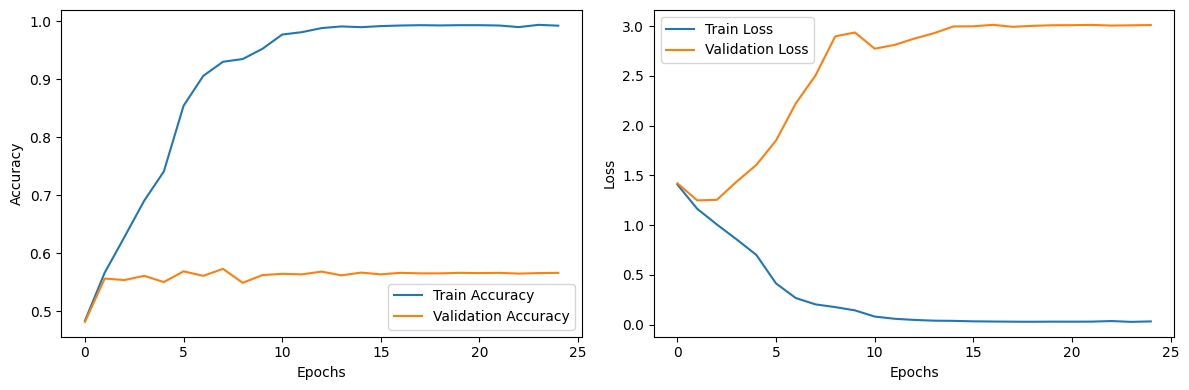

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Accuracy
axs[0].plot(history16hog.history['accuracy'], label='Train Accuracy')
axs[0].plot(history16hog.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot the Loss
axs[1].plot(history16hog.history['loss'], label='Train Loss')
axs[1].plot(history16hog.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()


plt.tight_layout()
plt.show()

#### Comments

Training the deep learner on HOG features, the accuracy is 2% better than before. But, from the above graphs, we can see that the model is severely overfitting the data  and would not generalise to unseen data well.

We conclude that model 16 despite its decent accuracy is not a very good model overall.

### Model 22

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model22 = keras.models.Sequential()
model22.add(keras.layers.Flatten(input_shape=[image_size,image_size]))
for _ in range(20):
    model22.add(keras.layers.Dense(100,
                                 activation="relu",
                                 kernel_initializer="he_normal"))

model22.add(keras.layers.Dense(7, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model22.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("Model22.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [ ]:
history22 = model22.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
219/219 [==============================] - 12s 16ms/step - loss: 1.8207 - accuracy: 0.2659 - val_loss: 1.7982 - val_accuracy: 0.3002
Epoch 2/100
  6/219 [..............................] - ETA: 2s - loss: 1.8477 - accuracy: 0.2552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 3s 13ms/step - loss: 1.7790 - accuracy: 0.2910 - val_loss: 1.7710 - val_accuracy: 0.3002
Epoch 3/100
219/219 [==============================] - 3s 13ms/step - loss: 1.7556 - accuracy: 0.2910 - val_loss: 1.7595 - val_accuracy: 0.3178
Epoch 4/100
219/219 [==============================] - 3s 13ms/step - loss: 1.7315 - accuracy: 0.3136 - val_loss: 1.7107 - val_accuracy: 0.3349
Epoch 5/100
219/219 [==============================] - 5s 21ms/step - loss: 1.6740 - accuracy: 0.3466 - val_loss: 1.6559 - val_accuracy: 0.3636
Epoch 6/100
219/219 [==============================] - 4s 19ms/step - loss: 1.6267 - accuracy: 0.3718 - val_loss: 1.6145 - val_accuracy: 0.4014
Epoch 7/100
219/219 [==============================] - 3s 13ms/step - loss: 1.5962 - accuracy: 0.3962 - val_loss: 1.6074 - val_accuracy: 0.4018
Epoch 8/100
219/219 [==============================] - 3s 13ms/step - loss: 1.5816 - accuracy: 0.4059 - val_loss: 1.5877 - val_accuracy: 0.4082
Epoc

In [ ]:
model22 = keras.models.load_model("Model22.h5")
model22.evaluate(X_valid, y_valid)

73/73 [==============================] - 0s 3ms/step - loss: 1.4562 - accuracy: 0.4670


[1.4562270641326904, 0.4669811427593231]

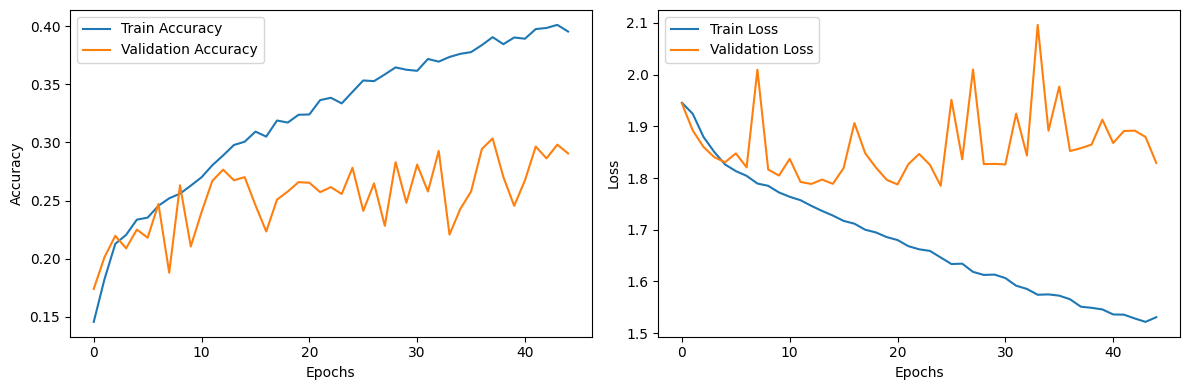

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Accuracy
axs[0].plot(history22.history['accuracy'], label='Train Accuracy')
axs[0].plot(history22.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot the Loss
axs[1].plot(history22.history['loss'], label='Train Loss')
axs[1].plot(history22.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()


plt.tight_layout()
plt.show()

#### Comments

For Model22 I implemented a Nadam Optimiser with a relu activation function.Without the balanced classes I was able to achieve an accuracy score of 46.7% on the validation set and 56% on the training set. It is also worth noting that I acieved the lowest validation loss for this modelof 1.4.

In terms of overfitting, the validation accuracy does jump around quite a bit but remains between 40-45%  which is okay and stays close to the training accuracy. This was a poorer performing model than Model16 on accuracy scores alone but in terms of loss and overfitting a much better one. This model would generalise better to unseen data.

In Model 23 I played around adding Batchnormalisation and a different activation function lets see if this increases our accuracy.

### Model 23

In [ ]:

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model23 = keras.models.Sequential()
model23.add(keras.layers.Flatten(input_shape=[image_size,image_size]))
model23.add(keras.layers.BatchNormalization())

for _ in range(20):
    model23.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model23.add(keras.layers.BatchNormalization())
    model23.add(keras.layers.Activation("elu"))
model23.add(keras.layers.Dense(7, activation="softmax"))


optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model23.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("DNN_BN_mod23.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [ ]:
history23 = model23.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
219/219 [==============================] - 35s 53ms/step - loss: 1.8283 - accuracy: 0.3120 - val_loss: 2.0080 - val_accuracy: 0.3002
Epoch 2/100
219/219 [==============================] - 11s 52ms/step - loss: 1.5680 - accuracy: 0.4180 - val_loss: 1.6725 - val_accuracy: 0.4027
Epoch 3/100
219/219 [==============================] - 10s 44ms/step - loss: 1.4806 - accuracy: 0.4508 - val_loss: 1.4830 - val_accuracy: 0.4580
Epoch 4/100
219/219 [==============================] - 8s 36ms/step - loss: 1.4188 - accuracy: 0.4763 - val_loss: 1.4935 - val_accuracy: 0.4610
Epoch 5/100
219/219 [==============================] - 8s 38ms/step - loss: 1.3777 - accuracy: 0.4900 - val_loss: 1.4905 - val_accuracy: 0.4533
Epoch 6/100
219/219 [==============================] - 8s 35ms/step - loss: 1.3515 - accuracy: 0.4996 - val_loss: 1.4976 - val_accuracy: 0.4648
Epoch 7/100
219/219 [==============================] - 10s 44ms/step - loss: 1.3067 - accuracy: 0.5139 - val_loss: 1.4303 - val_accur

In [ ]:
model23 = keras.models.load_model("DNN_BN_mod23.h5")
model23.evaluate(X_valid, y_valid)

73/73 [==============================] - 1s 5ms/step - loss: 1.5024 - accuracy: 0.4164


[1.5024219751358032, 0.41638079285621643]

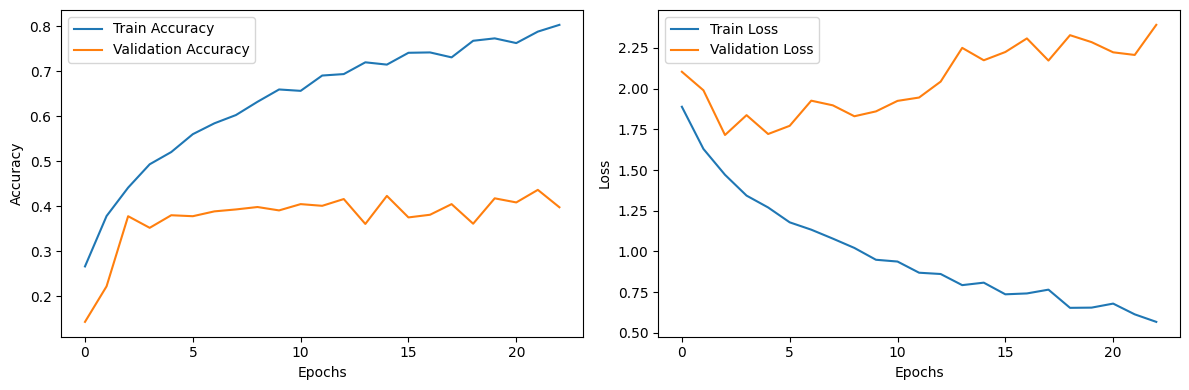

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Accuracy
axs[0].plot(history23.history['accuracy'], label='Train Accuracy')
axs[0].plot(history23.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot the Loss
axs[1].plot(history23.history['loss'], label='Train Loss')
axs[1].plot(history23.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()


plt.tight_layout()
plt.show()

#### Comments

When running Model23, I found that the batchnormalised layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster. Playing around with the relu and elu activation functions I found that elu and Batch normalisation performed 2% better (46% RELU- Batchnormalisation vs 48% ELU-Batchnormalisation).ELU was able to give me the best accuracy of 51.2% and a loss of 1.41.

Therefore I decided batch norm with ELU is best to move forward with. When I submitted the Model23 trained on HOG features to Kaggle, it yeilded aan accuracy of 53% which was the best performing for the deep learners.


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model23hog = keras.models.Sequential()
#model23.add(keras.layers.Flatten(input_shape=[image_size,image_size]))
model23hog.add(keras.layers.BatchNormalization())

for _ in range(20):
    model23hog.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model23hog.add(keras.layers.BatchNormalization())
    model23hog.add(keras.layers.Activation("elu"))
model23hog.add(keras.layers.Dense(7, activation="softmax"))


optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model23hog.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("DNN_BN_mod23hog.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [ ]:
model23hog.fit(X_train_hog, y_train, epochs=100,
          validation_data=(X_valid_hog, y_valid),
          callbacks=callbacks)



Epoch 1/100
218/219 [============================>.] - ETA: 0s - loss: 1.7099 - accuracy: 0.3767

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 41s 41ms/step - loss: 1.7102 - accuracy: 0.3768 - val_loss: 1.6525 - val_accuracy: 0.4198
Epoch 2/100
219/219 [==============================] - 8s 37ms/step - loss: 1.3998 - accuracy: 0.4879 - val_loss: 1.3966 - val_accuracy: 0.4914
Epoch 3/100
219/219 [==============================] - 10s 48ms/step - loss: 1.3012 - accuracy: 0.5177 - val_loss: 1.3352 - val_accuracy: 0.5073
Epoch 4/100
219/219 [==============================] - 12s 53ms/step - loss: 1.2289 - accuracy: 0.5436 - val_loss: 1.3312 - val_accuracy: 0.5086
Epoch 5/100
219/219 [==============================] - 12s 53ms/step - loss: 1.1730 - accuracy: 0.5719 - val_loss: 1.2988 - val_accuracy: 0.5236
Epoch 6/100
219/219 [==============================] - 12s 53ms/step - loss: 1.1073 - accuracy: 0.5936 - val_loss: 1.3680 - val_accuracy: 0.5227
Epoch 7/100
219/219 [==============================] - 7s 33ms/step - loss: 1.0736 - accuracy: 0.6038 - val_loss: 1.3343 - val_accuracy: 0.5232

In [ ]:
model23 = keras.models.load_model("DNN_BN_mod23hog.h5")
model23.evaluate(X_valid_hog, y_valid)

73/73 [==============================] - 2s 9ms/step - loss: 1.2931 - accuracy: 0.5279


[1.2930809259414673, 0.5278730988502502]

#### Comments:

The deep learner trained on the HOG features performs marginally better as I mentioned before. The model does tend to overfit severely from epoch 12 onwards and the implementation of early stopping does not only save resources but further prevents overfitting of the model.

For these reasons I chose to go ahead and reserve Model23 as one of the deep learners I would use to predict on the private test set. I was able to get an accuracy 53% but did not submit these predictions as it was lower than the SVC classifier.



In [ ]:
model23.save('/content/drive/MyDrive/Masters2022-2024/COMP8220-MachineLearning/MajorProject/DNN_BN_mod23hog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 24

For model 24 I implemented Dropout and Montecarlo Dropout.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model24 = keras.models.Sequential()
model24.add(keras.layers.Flatten(input_shape=[image_size,image_size]))
model24.add(keras.layers.BatchNormalization())

for _ in range(20):
    model24.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model24.add(keras.layers.BatchNormalization())
    model24.add(keras.layers.Activation("elu"))

model24.add(keras.layers.Dropout(rate=0.3))
model24.add(keras.layers.Dense(7, activation="softmax"))


optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model24.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("DNN_BN_mod24.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [ ]:
model24.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)



Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 2.0494 - accuracy: 0.2596

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 30s 41ms/step - loss: 2.0494 - accuracy: 0.2596 - val_loss: 2.1437 - val_accuracy: 0.3006
Epoch 2/100
219/219 [==============================] - 8s 37ms/step - loss: 1.7566 - accuracy: 0.3561 - val_loss: 1.7320 - val_accuracy: 0.3439
Epoch 3/100
219/219 [==============================] - 8s 38ms/step - loss: 1.6297 - accuracy: 0.4068 - val_loss: 1.5315 - val_accuracy: 0.4425
Epoch 4/100
219/219 [==============================] - 8s 35ms/step - loss: 1.5584 - accuracy: 0.4354 - val_loss: 1.5206 - val_accuracy: 0.4520
Epoch 5/100
219/219 [==============================] - 10s 44ms/step - loss: 1.4923 - accuracy: 0.4528 - val_loss: 1.4808 - val_accuracy: 0.4631
Epoch 6/100
219/219 [==============================] - 11s 51ms/step - loss: 1.4520 - accuracy: 0.4771 - val_loss: 1.4313 - val_accuracy: 0.4781
Epoch 7/100
219/219 [==============================] - 13s 58ms/step - loss: 1.3990 - accuracy: 0.4854 - val_loss: 1.4690 - val_accuracy: 0.4653


In [ ]:
model24 = keras.models.load_model("DNN_BN_mod24.h5")
model24.evaluate(X_valid, y_valid)

73/73 [==============================] - 1s 5ms/step - loss: 1.4165 - accuracy: 0.4910


[1.4165335893630981, 0.4909948408603668]

#### Comments

Dropout and Montecarlo Dropout is another regularisation technique that can be very useful in combatting the vanishing/ exploding gradients problem. Essentially dropout forces the model to adjust its weights when some of the neurons 'drop out' and this helps the overall model generalise better to unseen data. After playing arounf with a number of different drop out rates I settled on 0.3. THe model Converged after 31 epochs at accuracy of 50.4%. Some signs of overfitting due to diverging testing and validation accuracies but lowest loss at 1.39.I found that regualr Dropout performs better than Alpha dropout.


Now trying with Montecarlo dropout:

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model24.layers
])

In [ ]:
# utility functions
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid)
accuracy = np.mean(y_pred == y_valid)
accuracy

73/73 [==============================] - 0s 4ms/step


0.49056603773584906

In [ ]:
# with drop out off

model24DO_off = keras.models.load_model("DNN_BN_mod24.h5")

In [ ]:
y_proba_24 = model24DO_off.predict(X_valid)
y_pred_24= np.argmax(y_proba_24, axis=1)
accuracy = np.sum(y_pred_24 == y_valid) / len(y_valid)
accuracy

73/73 [==============================] - 1s 4ms/step


0.49099485420240135

#### Comments

There is only a marginal difference between non-dropout and drop out in Model24
MC dropout as a regularisation technique is not all that better, so we will be going ahead with batch normalisation since that yielded the highest accuracy.

# Transfer Learning

Transfer learning from a pretrained model is especially useful when we dont have a particularly large dataset. It leverages pretrained models that have been trained on a large scale set of images. We can take advantage of the generic model trained for our own analyses.

For the purposes of this project I have chosen to implement a VGG16 and MobileNetV2 model.

For this section of the major project, I will be exclusively using the balanced training and validation sets.


### Data Augmentation:

To introduce some variation and diversity into our dataset I implemented some simple data augmentation techniques such as RandomZoom and roation. This will help expose the model to different aspects of the images and hopefully reduce overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomRotation(0.2)
])



## VGG16

In this section I fit a VGG16 model using transfer learning
I tried different regularisation techniques such as L1, L2, dropout.

In general, I struggled with playing around with the tranfer learning models to get rid of the vanishing gradients issue. I think I lacked the understanding to create simple layers with common activation functions. I often over complicated the transfer learning models which did not yield notable accuracies.

In [ ]:

def plot_history(model,epoch):
  history = model.history
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epoch)

  plt.figure(figsize=(15, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


In [ ]:
vgg16 = VGG16(weights ="imagenet",
              include_top =False,
              input_shape=(48, 48, 3))

vgg16.trainable =True
fine_tune_at = 100
for layer in vgg16.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Add L1 regularization to the dense layer
regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(3, (1, 1), padding='same', input_shape=(48, 48, 1)),
    vgg16,
    layers.BatchNormalization(),  # Add batch normalization after the convolutional layer
    layers.Flatten(),             # Flatten the output before dense layers
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizer),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizer),
    layers.BatchNormalization(),

    layers.Dense(7, activation='softmax')
])

In [ ]:
model.build((64,48,48, 1))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_18 (Conv2D)          (64, 48, 48, 3)           6         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization_31 (Ba  (64, 1, 1, 512)           2048      
 tchNormalization)                                               
                                                                 
 flatten_9 (Flatten)         (64, 512)                 0         
                                                                 
 dense_44 (Dense)            (64, 1024)                525312    
                                                     

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001, rho=0.9)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("VGG16_test.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb,lr_scheduler]

In [ ]:
batch_size = 64
epochs=100

history = model.fit(X_train,y_train,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size),
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size = batch_size
)

Epoch 1/100
115/116 [============================>.] - ETA: 0s - loss: 337.5857 - accuracy: 0.1626

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 9s 28ms/step - loss: 337.5394 - accuracy: 0.1627 - val_loss: 331.8453 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 2/100
116/116 [==============================] - 3s 26ms/step - loss: 326.8369 - accuracy: 0.1736 - val_loss: 321.6547 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 3/100
116/116 [==============================] - 4s 32ms/step - loss: 316.2993 - accuracy: 0.1818 - val_loss: 313.8239 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 4/100
116/116 [==============================] - 4s 39ms/step - loss: 305.8784 - accuracy: 0.1845 - val_loss: 312.5374 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 5/100
116/116 [==============================] - 3s 27ms/step - loss: 295.5359 - accuracy: 0.2024 - val_loss: 351.6599 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 6/100
116/116 [==============================] - 3s 26ms/step - loss: 285.3794 - accuracy: 0.1978 - val_loss: 391.9713 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 7/100
116/116 [=

In [ ]:
model.evaluate(X_valid, y_valid)

59/59 [==============================] - 0s 7ms/step - loss: 6.1700 - accuracy: 0.2175


[6.17003059387207, 0.21750806272029877]

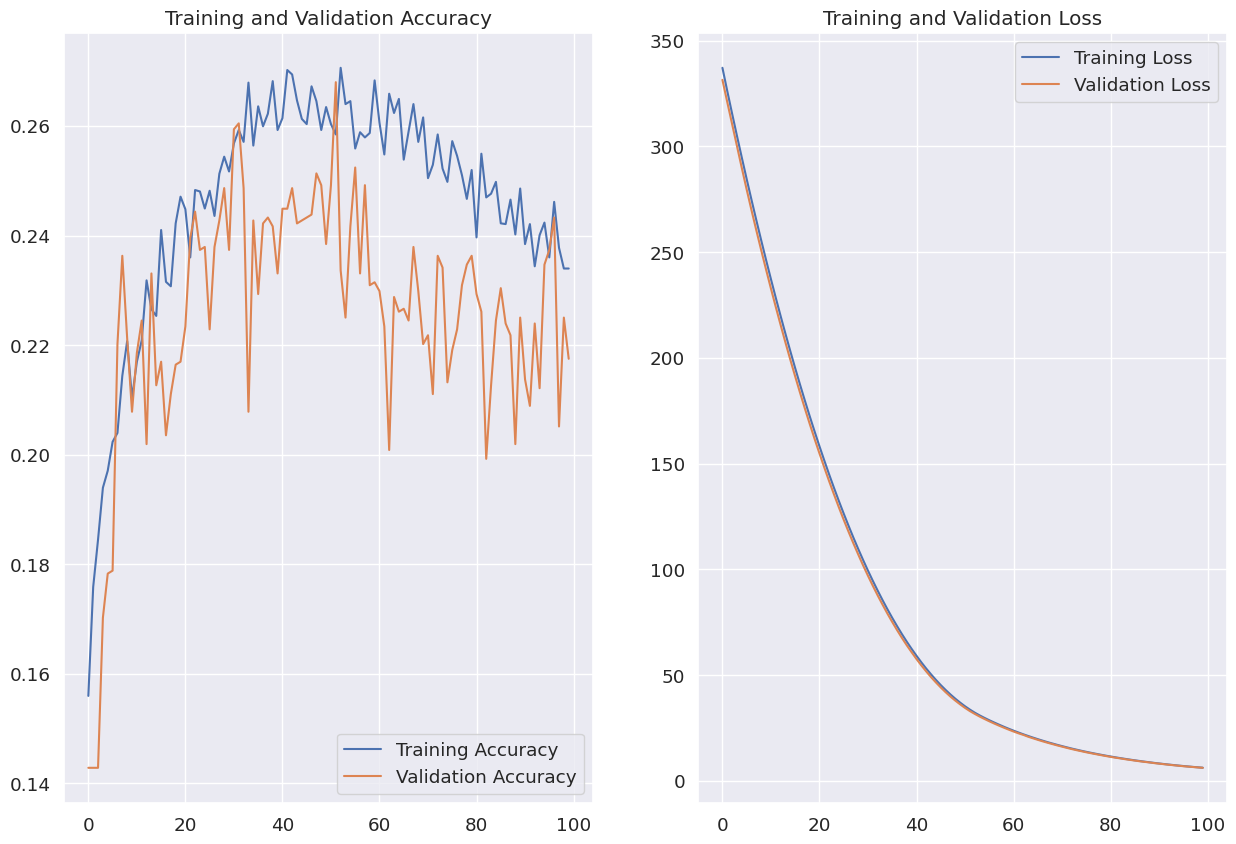

In [ ]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(15, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### Comments

The VGG16 Model was not at all effective in finding a good accuracy for this image dataset. I played around with a few optimisation functions such as Adam, Nadam, SGD and RMSProp. All except RMSProp produced the vanishing gradients problem and validation accuracies that plateaued at 15% Accuracy.

I also tried different activation functions like Relu, elu and selu but still experienced the vanishing gradients problem. Upon researching further, models like VGG16 are often prone to the vanishing gradients problem.

Implementing regularisation techniques such as Batch Normalisation didn't helpt too much as I got an accuracy value of 16%. Dropout didn't help but when implemented L1 and L2 regularisation the accuracy improved to 22%. This is because  L1L2 regularization can help in preventing overfitting and improving the model's generalization ability.

But you can see from the graph above, the validation and training accuracies fluctuate violently a sure sign that the data is being overfitted. Researching further,
VGG16 has a large number of parameters, which makes it prone to overfitting especially if the data we feed it is small and lacks diversity. Our data set is relatively small and lacks distinct variability. While VGG16 is suitable for image classification tasks, its not the best for face detection tasks. I think in future I need to keep the layers I place on top of the trained model as simple as possible.

# Mobile Net V2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Add L1 regularization to the dense layer
regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

model = tf.keras.Sequential([
    data_augmentation,
    layers.Conv2D(3, (1, 1), padding='same', input_shape=(48, 48, 1)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(7, activation='softmax')
])

In [ ]:
model.build((64,48,48, 1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (64, 48, 48, 3)           6         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (64, 1280)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (64, 512)                 655872    
                                                                 
 batch_normalization_6 (Bat  (64, 512)                

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum =0.9)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("MobileVnet.h5", save_best_only=True)
lr_scheduler  = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
run_index = 1 # increment every time you train the model
callbacks = [early_stopping_cb, model_checkpoint_cb,lr_scheduler]


batch_size = 50

history = model.fit(X_train,y_train,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=(X_valid, y_valid),
                    epochs=100,
                    callbacks=callbacks,
                    batch_size = batch_size
)

Epoch 1/100
138/139 [============================>.] - ETA: 0s - loss: 1.8548 - accuracy: 0.2765

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 15s 47ms/step - loss: 1.8541 - accuracy: 0.2767 - val_loss: 29.1606 - val_accuracy: 0.1003 - lr: 0.0100
Epoch 2/100
139/139 [==============================] - 4s 28ms/step - loss: 1.7796 - accuracy: 0.2889 - val_loss: 88.5705 - val_accuracy: 0.1003 - lr: 0.0100
Epoch 3/100
139/139 [==============================] - 4s 29ms/step - loss: 1.7827 - accuracy: 0.2917 - val_loss: 100.2393 - val_accuracy: 0.1149 - lr: 0.0100
Epoch 4/100
139/139 [==============================] - 5s 36ms/step - loss: 1.7798 - accuracy: 0.2915 - val_loss: 146.3768 - val_accuracy: 0.1149 - lr: 0.0100
Epoch 5/100
139/139 [==============================] - 5s 33ms/step - loss: 1.7764 - accuracy: 0.2912 - val_loss: 299.0219 - val_accuracy: 0.1149 - lr: 0.0100
Epoch 6/100
139/139 [==============================] - 4s 28ms/step - loss: 1.7788 - accuracy: 0.2891 - val_loss: 371.3904 - val_accuracy: 0.1149 - lr: 0.0050



#### Comments

  Similar to VGG16, I really struggled in playing around with the MobileVNet pretrained learner. I over complicated the additional layers added to the model and even with peice wise scheduling, the accuracy never improved beyond 10%. Even with using different optimisers, activation functions and different dropout rates I was not able to get the model to generalise better. And this was because I needed to reduce the number of the layers and use common activation functions such as RELU rather than ELU.




  

# Overall Conclusion

Throughout this project I learned alot about image processing the world of image recognition and deep learning techniques. This project was challenging especially when it came to the transfer learning component. VGG16 especially only dealt with color images so finding a way to reshape and manipulate the input so that the model took grayscale images was challenging. Even though the transfer learning models didnt perform as well as I'd hoped, it definitely gives me a chance to work on this in my spare time and improve the model so that it does work and spits out a decent accuracy score.

In terms of the accuracies compared to the Kaggle leaderboard competition;
like I mentioned above, the balanced classes would have been a more robust approach but, I opted for the unbalanced class approach. In the end, for the public data set I got an accuracy of 61.1% which placed me 19th on the leaderboard. This was in comparison to 78% for the top accuracy. The benchmark for the majority of the competition was 60% so I wanted to make sure that atleast my conventional machine learner was able to achieve atleast 60% accuracy which I did. The deep learning models got reasonably close to the 60% mark but I think more data is needed to truly improve the deep learner. I also should have implemented k-fold sampling to train the deep learner.


For the private test set I decided to use the SVC classifier on the scaled HOG inputs. This resulted in a 62.7% accuracy and placed me 16th on the leader board. The top accuracy was 80% which a great feat especially beacuse this person had used an additional 45 thousand images and transfer learning.

While I was not able to produce a great predictive learner I am glad now atleast I have a good foundation for deep learning techniques to develop further in my spare time.

